In [1]:
import numpy as np
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Activation, Dropout, UpSampling2D
from keras.layers import Conv2DTranspose, Conv2D, MaxPooling2D,Bidirectional,Reshape,Flatten,TimeDistributed,LSTM
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
import matplotlib.pyplot as plt
import time
import random
import math
from PIL import Image
from keras.models import load_model

In [2]:
train_images = pickle.load(open("data/full_CNN_train.p", "rb" ))
labels = pickle.load(open("data/full_CNN_labels.p", "rb" ))

In [3]:
print("dataset",type(train_images))
print(type(labels))

train_images = np.array(train_images)
labels = np.array(labels)
print(train_images.shape)
print(labels.shape)

dataset <class 'list'>
<class 'list'>
(12764, 80, 160, 3)
(12764, 80, 160, 1)


In [4]:
# new_shape = (224,224)

# resized_images = []
# for i in range(train_images.shape[0]):
#     image = Image.fromarray(np.uint8(train_images[i]))
#     image = image.resize(new_shape)
#     resized_images.append(np.array(image))

# train_images = np.array(resized_images)


# print(train_images.shape) # (12764, 224, 224, 3)

# new_shape = (224,224)

# resized_images = []
# for i in range(labels.shape[0]):
#     image = Image.fromarray(np.uint8(labels[i][:,:,0]))
#     image = image.resize(new_shape, resample=Image.NEAREST)
#     resized_images.append(np.expand_dims(np.array(image), axis=-1))

# labels = np.array(resized_images)
# print(labels.shape) # (12764, 224, 224, 1)

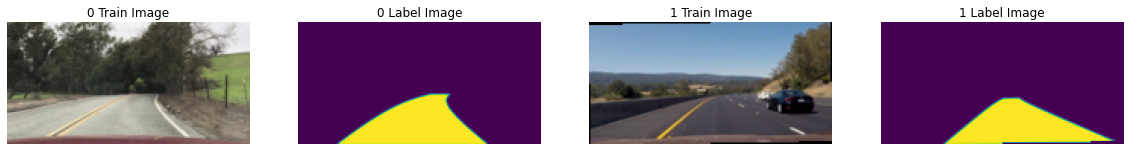

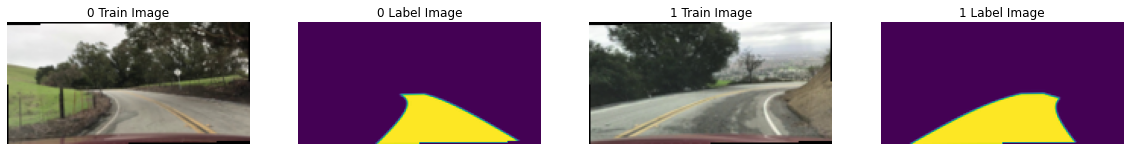

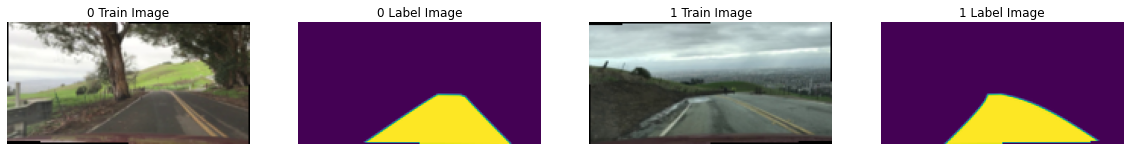

In [5]:
n = 2
indices = random.sample(range(len(train_images)), n)

# Plot each image and label
fig, axs = plt.subplots(1, 2 * n, figsize=(20, 5))
for i, index in enumerate(indices):
    axs[2 * i].imshow(train_images[index])
    axs[2 * i].set_title(f'{i} Train Image')
    axs[2 * i].axis('off')
    
    axs[2 * i + 1].imshow(labels[index])
    axs[2 * i + 1].set_title(f'{i} Label Image')
    axs[2 * i + 1].axis('off')

plt.show()

n = 2
indices = random.sample(range(len(train_images)), n)

# Plot each image and label
fig, axs = plt.subplots(1, 2 * n, figsize=(20, 5))
for i, index in enumerate(indices):
    axs[2 * i].imshow(train_images[index])
    axs[2 * i].set_title(f'{i} Train Image')
    axs[2 * i].axis('off')
    
    axs[2 * i + 1].imshow(labels[index])
    axs[2 * i + 1].set_title(f'{i} Label Image')
    axs[2 * i + 1].axis('off')

plt.show()

n = 2
indices = random.sample(range(len(train_images)), n)

# Plot each image and label
fig, axs = plt.subplots(1, 2 * n, figsize=(20, 5))
for i, index in enumerate(indices):
    axs[2 * i].imshow(train_images[index])
    axs[2 * i].set_title(f'{i} Train Image')
    axs[2 * i].axis('off')
    
    axs[2 * i + 1].imshow(labels[index])
    axs[2 * i + 1].set_title(f'{i} Label Image')
    axs[2 * i + 1].axis('off')

plt.show()

# Model Train

In [6]:
labels = labels / 255

In [7]:
train_images, labels = shuffle(train_images, labels)
X_train, X_val, y_train, y_val = train_test_split(train_images, labels, test_size=0.25)

In [8]:
X_train.shape,y_train.shape, X_val.shape,y_val.shape

((9573, 80, 160, 3),
 (9573, 80, 160, 1),
 (3191, 80, 160, 3),
 (3191, 80, 160, 1))

In [29]:
def create_model(input_shape):
    
    model = Sequential()
    
    ## Encoder Network
    model.add(BatchNormalization(input_shape=input_shape))
    model.add(Conv2D(8, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv1'))
    model.add(Conv2D(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv2'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv3'))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv4'))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv5'))
    model.add(Dropout(0.2))
    
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv6'))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    ##LSTM layer
    model.add(Conv2D(64, (3,3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv7'))
    model.add(Reshape((5 * 15, 64)))
    model.add(Bidirectional(LSTM(64, activation='tanh', return_sequences=True,name = 'BiLSTM1')))
    model.add(Reshape((5, 15, 128)))
    model.add(Conv2D(128, (3,3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv8'))
    model.add(Reshape((3 * 13, 128)))
    model.add(Bidirectional(LSTM(128, activation='tanh', return_sequences=True,name = 'BiLSTM2')))
    model.add(Reshape((3,13, 256)))
    
    
    ## Decoder Network
#     # Deconvolutional layers
    model.add(Conv2DTranspose(128, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv1'))
    model.add(Dropout(0.2))
    model.add(Conv2DTranspose(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv2'))
    model.add(Dropout(0.2))
    # Upsample 1
    model.add(UpSampling2D(size=(2,2)))
    model.add(Conv2DTranspose(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv3'))
    
    # Upsample 2
    model.add(UpSampling2D(size=(2,2)))
    model.add(Conv2DTranspose(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv4'))
    model.add(Dropout(0.2))
    model.add(Conv2DTranspose(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv5'))
    model.add(Dropout(0.2))
    model.add(Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv6'))
    model.add(Dropout(0.2))
    
    # Upsample 3
    model.add(UpSampling2D(size=(2,2)))
    model.add(Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv7'))
    # Final layer - only including one channel so 1 filter
    model.add(Conv2DTranspose(1, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Final'))

    return model

In [30]:
input_shape = X_train.shape[1:]

model = create_model(input_shape)
model.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_9 (Batc  (None, 80, 160, 3)       12        
 hNormalization)                                                 
                                                                 
 Conv1 (Conv2D)              (None, 78, 158, 8)        224       
                                                                 
 Conv2 (Conv2D)              (None, 76, 156, 16)       1168      
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 38, 78, 16)       0         
 g2D)                                                            
                                                                 
 Conv3 (Conv2D)              (None, 36, 76, 16)        2320      
                                                                 
 dropout_41 (Dropout)        (None, 36, 76, 16)       

In [20]:
# Using a generator to help the model use less data
datagen = ImageDataGenerator(channel_shift_range=0.2)
datagen.fit(X_train)


# Compiling and training the model
model.compile(optimizer='Adam', loss='mean_squared_error',metrics=['accuracy'])

start_time = time.time()

history=model.fit(datagen.flow(X_train, y_train, batch_size=64), steps_per_epoch=len(X_train)/64,
epochs=1, verbose=1,validation_data=(X_val,y_val))

# Measure the end time
end_time = time.time()

  5/149 [>.............................] - ETA: 3:21:49 - loss: 0.2562 - accuracy: 0.8010

KeyboardInterrupt: 

In [12]:
# Calculate the time taken
time_taken = end_time - start_time
print("Time taken to run the model: ", time_taken, "seconds")

Time taken to run the model:  772.369279384613 seconds


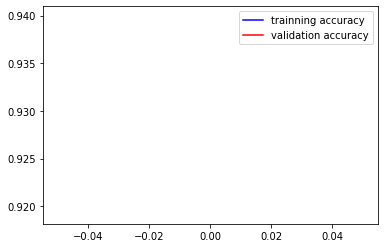

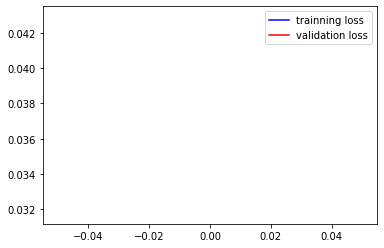

In [13]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

In [14]:
evaluation=model.evaluate(X_val,y_val)
print(evaluation)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

120/120 [==============================] - 71s 594ms/step - loss: 0.0317 - accuracy: 0.9399
[0.031731076538562775, 0.9399272203445435]
Test Accuracy : 93.99%


## Performance Calculation

In [15]:
prediction = model.predict(X_val)

In [16]:
def false_positive_negative(prediction, ground_truth):
    false_positive = 0
    false_negative = 0
    for i in range(prediction.shape[0]):
        for j in range(prediction.shape[1]):
            if prediction[i][j] == 255 and ground_truth[i][j] == 0:
                false_positive += 1
            elif prediction[i][j] == 0 and ground_truth[i][j] == 255:
                false_negative += 1
    return false_positive, false_negative

In [17]:
false_pos, false_neg = false_positive_negative(prediction.argmax(axis=0),y_val.argmax(axis=0))

In [18]:
print("Total FP : ",false_pos," Total Percentage: ",np.round((false_pos/prediction.shape[0])*100,2))
print("Total FN : ",false_neg," Total Percentage: ",np.round((false_neg/prediction.shape[0])*100,2))

Total FP :  0  Total Percentage:  0.0
Total FN :  0  Total Percentage:  0.0


In [19]:
precision = 100 * (1 - false_pos / (false_pos + 100 - false_neg))
recall = 100 * (1 - false_neg / (false_neg + 100 - false_pos))
print("F1_Score: ",2 * (precision * recall) / (precision + recall))

F1_Score:  100.0


In [23]:
def iou(prediction, ground_truth):
    intersection = (prediction & ground_truth).sum()
    union = (prediction | ground_truth).sum()
    iou = intersection / union
    iou_percentage = iou * 100
    return iou

In [26]:
iou(prediction.argmax(axis=0),y_val.argmax(axis=0))

0.031213137081469746

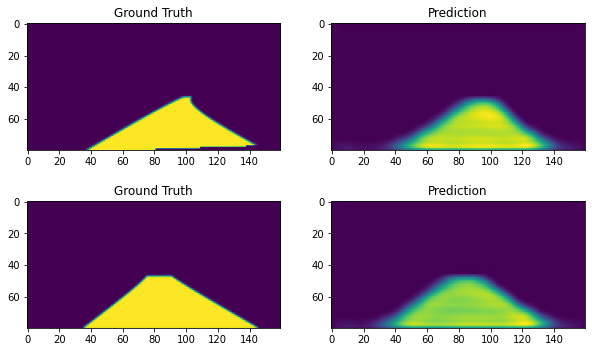

In [28]:
# Plot some random images from y_val
num_images = 2
random_indices = np.random.randint(0, y_val.shape[0], size=num_images)
y_val_images = y_val[random_indices]

# Get the corresponding predictions
predictions = model.predict(X_val[random_indices])

fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images*3))
for i in range(num_images):
    axes[i, 0].imshow(y_val_images[i])
    axes[i, 0].set_title('Ground Truth')
    axes[i, 1].imshow(predictions[i])
    axes[i, 1].set_title('Prediction')
plt.show()

## Complexity

In [29]:
# Get the number of parameters
num_params = model.count_params()

# Print the number of parameters
print("Number of parameters:", num_params)

# Calculate the memory requirement in bytes
memory_requirement = num_params * 4

# Print the memory requirement in bytes
print("Size:", memory_requirement, "bytes")


Number of parameters: 990397
Size: 3961588 bytes


In [ ]:
# model.save('full_CNN_model.h5')